In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from pylab import rcParams
mm=200  ##szórás és mozgóátlag
pdl=100 ##előrejelzett napok száma
import yfinance as yf
print('Modulok betöltöttek')
#pip install statsmodels==0.11.0 csak ezzel megy ujabbal nem fog.
#forrás: https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/
#https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html

Modulok betöltöttek


In [2]:
#Adatok letöltése a megfelelö paraméterekkel
szimbolum = 'TCEHY'
#last 5 years data with interval of 1 day
adatok = yf.download(tickers=szimbolum,period='5y',interval='1d')
adatok

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-02-08,26.250000,26.350000,26.160000,26.309999,25.980501,562000
2017-02-09,26.420000,26.500000,26.340000,26.480000,26.148369,352900
2017-02-10,26.180000,26.320000,26.150000,26.280001,25.950876,463200
2017-02-13,26.299999,26.389999,26.250000,26.330000,26.000252,491800
2017-02-14,26.240000,26.250000,26.030001,26.250000,25.921251,437800
...,...,...,...,...,...,...
2022-02-01,62.709999,62.779999,61.950001,62.750000,62.750000,5281300
2022-02-02,62.619999,62.750000,61.549999,62.119999,62.119999,6016300
2022-02-03,61.369999,62.349998,61.209999,61.680000,61.680000,7105200


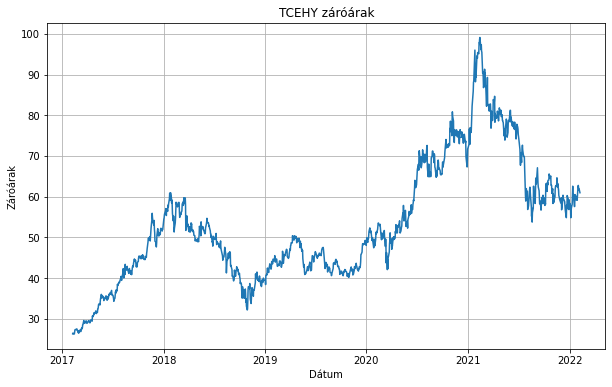

In [3]:
#Adatok megjelenitése
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dátum')
plt.ylabel('Záróárak')
plt.plot(adatok['Close'])
plt.title(szimbolum +" záróárak")
plt.show()

<AxesSubplot:ylabel='Density'>

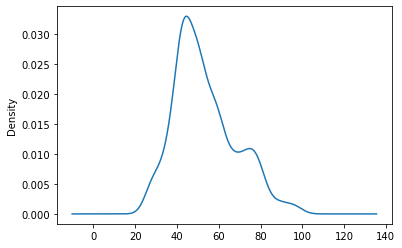

In [4]:
#Adatok eloszlása
zaro_arak = adatok['Close']
zaro_arak.plot(kind='kde')

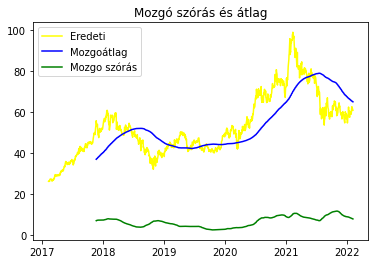

Dicker Fuller teszt eredménye: 
<class 'tuple'>
Test Statistics                  -1.912873
p-value                           0.326029
No. of lags used                  3.000000
Number of observations used    1255.000000
critical value (1%)              -3.435571
critical value (5%)              -2.863846
critical value (10%)             -2.567998
dtype: float64


In [5]:
def dickey_fuller(timeseries):
    #Mozogó átlag és mozogó szórás meghatározása
    mozgo_atlag = timeseries.rolling(mm).mean()
    mozgo_szoras = timeseries.rolling(mm).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Eredeti')
    plt.plot(mozgo_atlag, color='blue', label='Mozgoátlag')
    plt.plot(mozgo_szoras, color='green', label = 'Mozgo szórás')
    plt.legend(loc='best')
    plt.title('Mozgó szórás és átlag')
    plt.show(block=False)
    print("Dicker Fuller teszt eredménye: ")
    difu = adfuller(timeseries,autolag='AIC')
    print(type(difu))
    erdm = pd.Series(difu[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])

    for key,values in difu[4].items():
        erdm['critical value (%s)'%key] =  values
    print(erdm)
dickey_fuller(zaro_arak)

<Figure size 432x288 with 0 Axes>

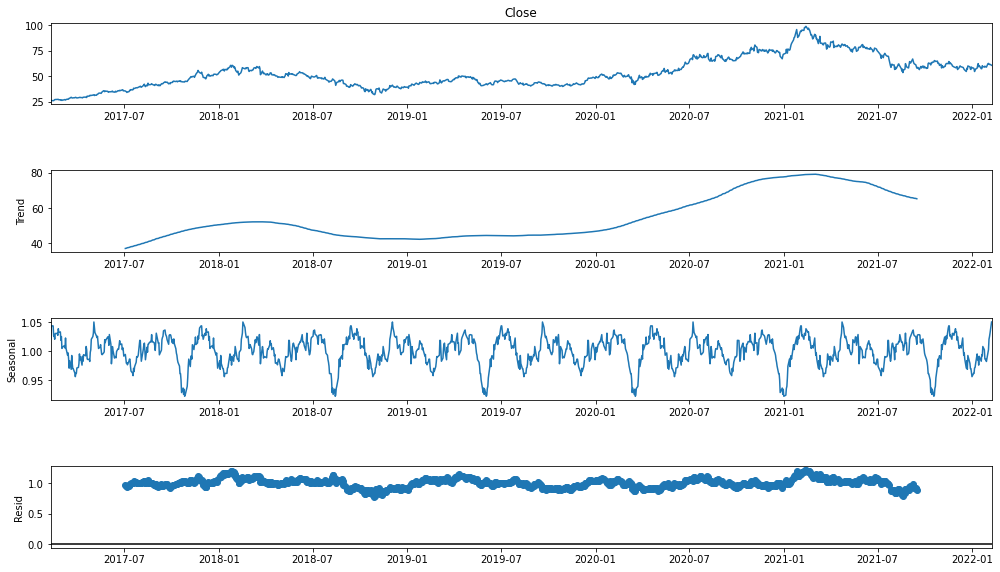

In [6]:
#Megnézni, hogy mit csinál
eredmenyek = seasonal_decompose(zaro_arak, model='multiplicative', freq = mm)
fig = plt.figure()  
fig = eredmenyek.plot()  
fig.set_size_inches(16, 9)


No handles with labels found to put in legend.


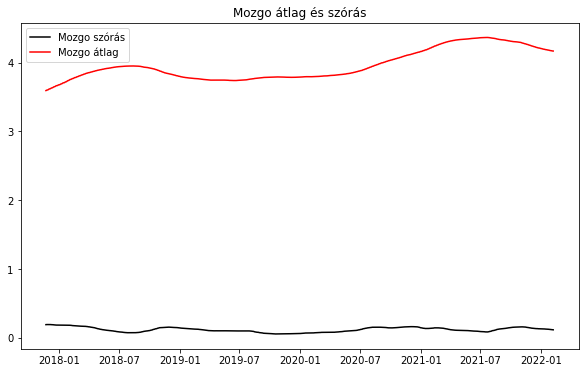

In [7]:
#Ezt is
rcParams['figure.figsize'] = 10, 6
log_adatok = np.log(zaro_arak)
mozg_atlag = log_adatok.rolling(mm).mean()
szoras = log_adatok.rolling(mm).std()
plt.legend(loc='best')
plt.title('Mozgo átlag és szórás')
plt.plot(szoras, color ="black", label = "Mozgo szórás")
plt.plot(mozg_atlag, color="red", label = "Mozgo átlag")
plt.legend()
plt.show()
log_adatok=zaro_arak

1067
<class 'pandas.core.series.Series'>


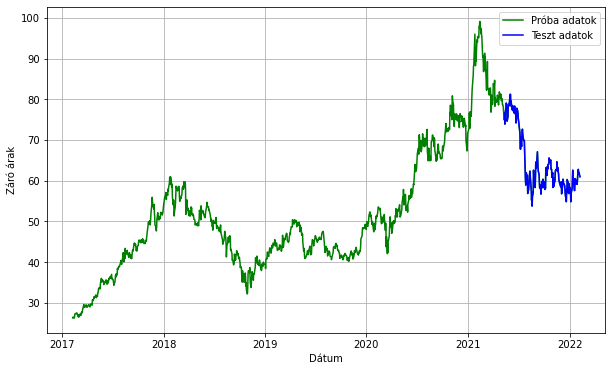

In [8]:
#Adatok két részre bontása probra és tesztre
proba_df, teszt_df = log_adatok[3:int(len(log_adatok)*0.85)], log_adatok[int(len(log_adatok)*0.85):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dátum')
plt.ylabel('Záró árak')
plt.plot(log_adatok, 'green', label='Próba adatok')
plt.plot(teszt_df, 'blue', label='Teszt adatok')
plt.legend()
print(len(proba_df))
print(type(teszt_df))


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3511.937, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3502.499, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3502.353, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3511.343, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3504.152, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3504.306, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3502.905, Time=1.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3502.152, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3504.040, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3504.128, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3502.250, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3502.602, Time=0.50 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.324 seconds
                               SARIMAX Results                                
Dep. Vari

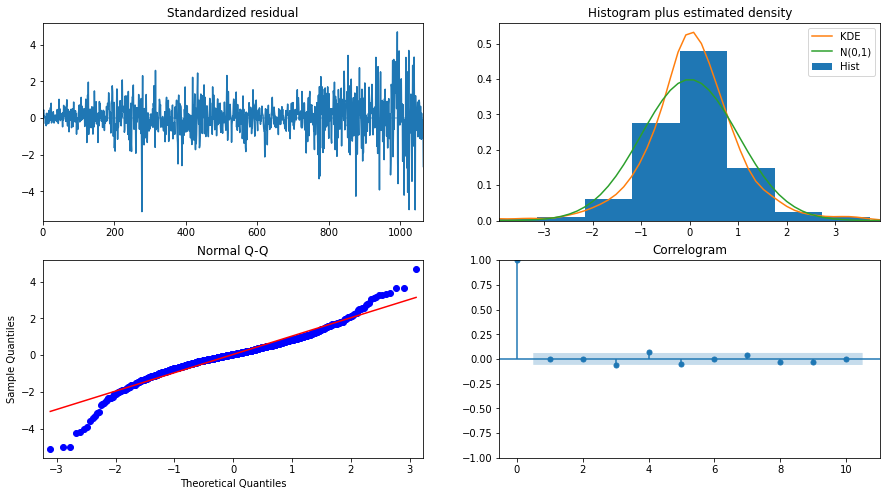

In [9]:
#Modell felépítése jobban leirni
model_autoARIMA = auto_arima(proba_df, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
print(model_autoARIMA.get_params())
print(model_autoARIMA.get_params()['order'])
plt.show()

In [10]:
#A legjobb modell létrehozása
model = ARIMA(proba_df, order=model_autoARIMA.get_params()['order'])  
fitted = model.fit(disp=-1)  
#+n nap létrehozása
#A teszt_dfben talált utolsó dátum_indexhez hozzá adunk n napot
vegso_datum = teszt_df.last_valid_index() + datetime.timedelta(days=pdl)
#létrehozunk egy új indexet a teszt_df első indexétől az utolső + n napig 
datum_30 = pd.date_range(start = teszt_df.first_valid_index(), end = vegso_datum, freq ='1D').strftime('%Y-%m-%d')
#létrehozunk egy listát az új index méretével
uj_teszadatok_bov=[]
for szam in range(len(datum_30)):
    uj_teszadatok_bov.append(szam)
#a listából datafremat csinálunk
bov_df = pd.DataFrame(uj_teszadatok_bov)
#beállítjuk a generált dátum indexet a listának
bov_df = pd.DataFrame(bov_df,index=datum_30)
#sorozatott csinálunk a listából.
bov_df=bov_df.squeeze()

#Elörejelzett adatok
elorejelzett_arfolyamok1,elorejelzett_arfolyamok2,elorejelzett_arfolyamok3=fitted.forecast(len(bov_df), alpha=0.05)
elorejelzett_arfolyamok = pd.Series(elorejelzett_arfolyamok1, index=bov_df.index)
print('Az elörejelzés átlaga: '+ str(elorejelzett_arfolyamok1.mean()))

# pandas sorozatok létrehozása:
#elörejelzett árak 
#elorejelzett_series = pd.Series(elorejelzett, index=teszt_df.index)
#Prediktált értékek kiíratása
print(elorejelzett_arfolyamok.tail(50))

Az elörejelzés átlaga: 83.83793036535484
2022-03-30    90.126573
2022-03-31    90.172475
2022-04-01    90.218378
2022-04-02    90.264280
2022-04-03    90.310183
2022-04-04    90.356085
2022-04-05    90.401988
2022-04-06    90.447890
2022-04-07    90.493793
2022-04-08    90.539695
2022-04-09    90.585598
2022-04-10    90.631500
2022-04-11    90.677403
2022-04-12    90.723305
2022-04-13    90.769208
2022-04-14    90.815110
2022-04-15    90.861013
2022-04-16    90.906915
2022-04-17    90.952818
2022-04-18    90.998720
2022-04-19    91.044623
2022-04-20    91.090525
2022-04-21    91.136428
2022-04-22    91.182330
2022-04-23    91.228233
2022-04-24    91.274135
2022-04-25    91.320038
2022-04-26    91.365940
2022-04-27    91.411843
2022-04-28    91.457745
2022-04-29    91.503648
2022-04-30    91.549550
2022-05-01    91.595453
2022-05-02    91.641355
2022-05-03    91.687258
2022-05-04    91.733160
2022-05-05    91.779063
2022-05-06    91.824965
2022-05-07    91.870868
2022-05-08    91.916770

C:\Users\Dell 5300\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Dell 5300\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


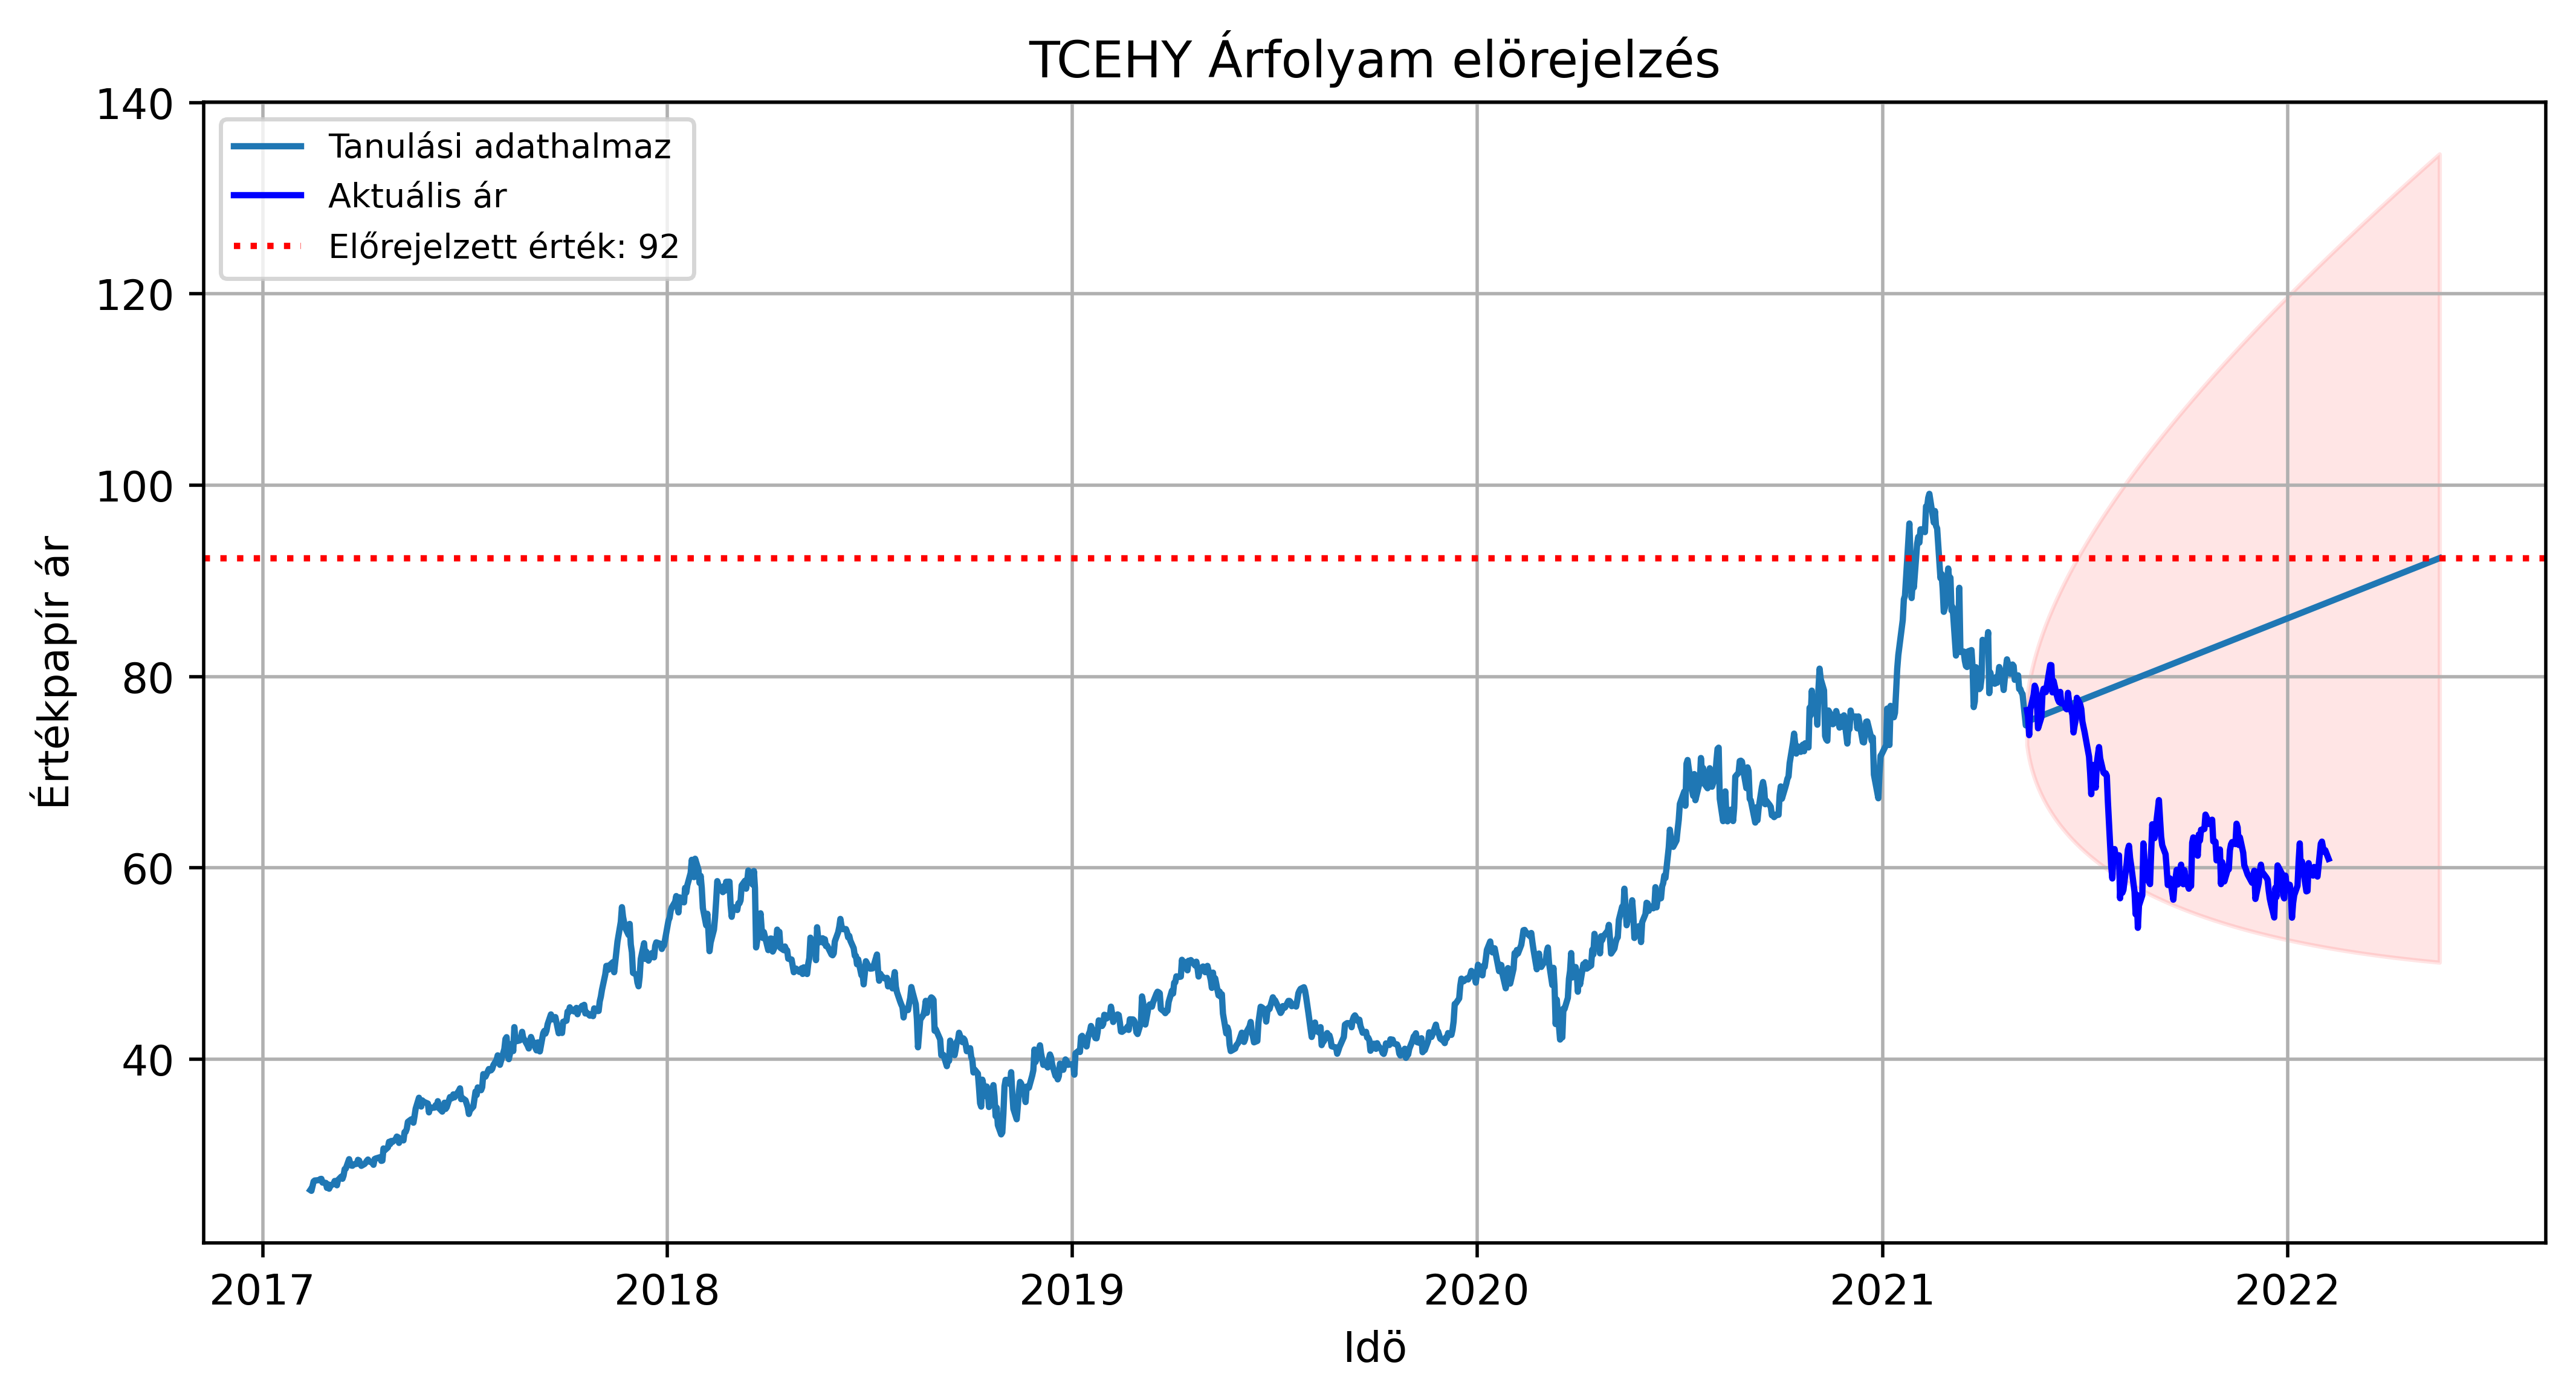

In [11]:
l1=[proba_df,elorejelzett_arfolyamok]
ujertekek = pd.concat(l1)
#tölcsér megcsinálása 95% konfidencia szinthez
lower_series = pd.Series(elorejelzett_arfolyamok3[:, 0], index=bov_df.index)
upper_series = pd.Series(elorejelzett_arfolyamok3[:, 1], index=bov_df.index)
# Diagram szerkesztése
plt.figure(figsize=(10,5), dpi=500)
plt.plot(ujertekek , label='Tanulási adathalmaz')
plt.plot(teszt_df, color = 'blue', label='Aktuális ár')
plt.fill_between(lower_series.index, lower_series, upper_series, color='red', alpha=.1)
plt.axhline(y=elorejelzett_arfolyamok1[len(elorejelzett_arfolyamok1)-1], color = 'red', linestyle = ':', label = 'Előrejelzett érték: {0}'.format(round(elorejelzett_arfolyamok1[len(elorejelzett_arfolyamok1)-1])))
plt.title(szimbolum+ ' Árfolyam elörejelzés')
plt.xlabel('Idö')
plt.ylabel('Értékpapír ár')
plt.legend(loc='upper left', fontsize=8)
plt.grid()
plt.show()